In [1]:
%%javascript
utils.load_extension("execute_time/ExecuteTime")
utils.load_extension('collapsible_headings/main') 

<IPython.core.display.Javascript object>

In [2]:
# Import candidate models
from doubt import Boot, QuantileRegressor, QuantileRegressionForest
from sklearn.linear_model import (LinearRegression, PoissonRegressor, 
                                  GammaRegressor, HuberRegressor)
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

# Import datasets
from doubt.datasets import (Airfoil, Blog, Concrete, CPU, 
                            FacebookComments, FishBioconcentration,
                            FishToxicity, ForestFire, NewTaipeiHousing,
                            PowerPlant, Protein, Servo,
                            SpaceShuttle, Yacht)

# Import external libraries
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from scipy.stats import ks_2samp, entropy, kruskal
import matplotlib.pyplot as plt; plt.style.use('ggplot')

import warnings
from collections import defaultdict
%matplotlib inline
from matplotlib import rcParams
plt.style.use('seaborn-whitegrid')
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['figure.figsize'] = 16,8

# Import internal classes
from distributions import DistributionShift
from src.psi import psi
from tqdm.notebook import tqdm

In [3]:
from xgboost import XGBRegressor
from tabulate import tabulate

In [4]:
dataset_classes = [
    Airfoil,
    Concrete,
    #FishToxicity,
    #ForestFire,
    #NewTaipeiHousing,
    #PowerPlant,
    #Protein,
    #Servo,
]

In [5]:
for dataset in dataset_classes:
    print(dataset().shape)

(1503, 6)
(908, 7)


In [6]:
def initialise_plot(
    num_rows: int, num_cols: int, base_regressor: type, dataset
):
    fig, axs = plt.subplots(
        num_rows,
        num_cols,
        sharex=True,
        sharey=True,
        figsize=(14, 3.5 * num_rows),
    )
    fig.suptitle(
        f"Monitoring plot for the {dataset.__name__} dataset under feature drift with {base_regressor.__name__}",
        fontsize=16,
    )
    for j in range(num_cols):
        axs[num_rows - 1, j].set_xlabel("Sorted columnd index")
    for i in range(num_rows):
        axs[i, 0].set_ylabel("Normalised values")
    return fig, axs

In [7]:
def kol_smi(x):
    return ks_2samp(x, BASE_COMP).statistic
def psi_stat(x):
    return psi(x, BASE_COMP)

In [15]:
def monitoring_plot(
    dataset,
    base_regressor: type,
    n_boots: int = 20,
    ROLLING_STAT: int = 100,
    plot: bool = True,
    **kwargs,
):

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # Initialise the scaler
        standard_scaler = StandardScaler()

        # Load the dataset and split it
        X, _, y, _ = dataset().split(test_size=0.001, random_seed=4242)

        # Scale the dataset
        X = standard_scaler.fit_transform(X)

        # Back to dataframe
        X = pd.DataFrame(X, columns=["Var %d" % (i + 1) for i in range(X.shape[1])])
        data = X.copy()
        data["target"] = y

        # Train test splitting points
        fracc = 0.33
        oneThird = int(data.shape[0] * fracc)
        twoThird = data.shape[0] - int(data.shape[0] * fracc)

        # Initialize plots
        num_rows = X.shape[1] // 3
        if X.shape[1] % 3 > 0:
            num_rows += 1
        fig, axs = initialise_plot(
            num_rows=num_rows,
            num_cols=3,
            base_regressor=base_regressor,
            dataset=dataset,
        )

        uncertainty_res = []
        ks_res = []
        psi_res = []
        for idx, col in tqdm(enumerate(X.columns), total=len(X.columns)):
            values = defaultdict(list)

            # Sort data on the column
            data = data.sort_values(col).reset_index(drop=True).copy()

            # Train Test Split
            data_sub = data.iloc[:oneThird]
            data_train = data.iloc[oneThird:twoThird]
            data_up = data.iloc[twoThird:]

            X_tot = data.drop(columns="target")
            X_tr = data_train.drop(columns="target")
            X_sub = data_sub.drop(columns="target")
            X_up = data_up.drop(columns="target")

            y_tot = data[["target"]].target.values
            y_tr = data_train[["target"]].target.values
            y_sub = data_sub[["target"]].target.values
            y_up = data_up[["target"]].target.values

            # Shap
            model = base_regressor(**kwargs)
            model.fit(X_tr,y_tr)
            model

            # Fit the regressor
            regressor = Boot(base_regressor(**kwargs))
            regressor.fit(X_tr, y_tr, n_boots=20)

            # Predictions
            preds, intervals = regressor.predict(
                X_tot, uncertainty=0.05, n_boots=n_boots
            )
            # pre
            d_sub, interval_sub = regressor.predict(
                X_sub.values.astype(object), uncertainty=0.05, n_boots=n_boots
            )

            # Statistics
            df = pd.DataFrame(
                intervals[:, 1] - intervals[:, 0], columns=["uncertainty"]
            )
            df["error"] = np.abs(preds - y_tot)

            ### KS Test
            df["ks"] = data[col]
            global BASE_COMP
            BASE_COMP = data[col]
            df[["ks"]] = (
                df[["ks"]].rolling(ROLLING_STAT, int(ROLLING_STAT * 0.5)).apply(kol_smi)
            )  # Takes ages
            ### PSI Test
            df["PSI"] = data[col]
            df[["PSI"]] = (
                df[["PSI"]]
                .rolling(ROLLING_STAT, int(ROLLING_STAT * 0.5))
                .apply(psi_stat)
            )  # Takes ages

            ### Rolling window on all
            df[df.columns[~df.columns.isin(["ks", "PSI"])]] = (
                df[df.columns[~df.columns.isin(["ks", "PSI"])]]
                .rolling(ROLLING_STAT, int(ROLLING_STAT * 0.5))
                .mean()
            ).dropna()

            ## Scaling
            df = df.dropna()
            df = pd.DataFrame(standard_scaler.fit_transform(df), columns=df.columns)

            # Convert to dic for plotting
            for index, col in enumerate(df.columns):
                    values[col] = df[col]

            uncertainty_res.append(
                mean_absolute_error(values["error"], values["uncertainty"])
            )
            ks_res.append(mean_absolute_error(values["error"], values["ks"]))
            psi_res.append(mean_absolute_error(values["error"], values["PSI"]))

            # Plotting
            if plot:
                for name, vals in values.items():
                    if idx == 0:
                        axs[idx // 3, idx % 3].plot(vals, label=f"{name} values")
                    else:
                        axs[idx // 3, idx % 3].plot(vals)
        resultados = pd.DataFrame(
            {"uncertainy": uncertainty_res, "ks": ks_res, "psi": psi_res}
        )
        print('Data',dataset.__name__)
        print(resultados.mean())
        resultados.loc["mean"] = resultados.mean()
        
        if plot:
            fig.legend()
            plt.savefig("fig.png")
            plt.show()
        return resultados

  0%|          | 0/5 [00:00<?, ?it/s]

Data Airfoil
uncertainy    0.700161
ks            0.779338
psi           1.021464
dtype: float64


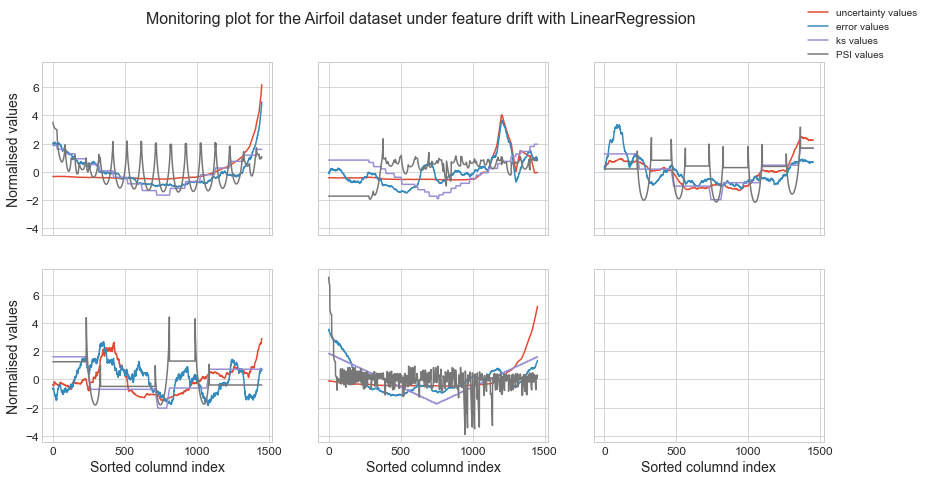

  0%|          | 0/6 [00:00<?, ?it/s]

Data FishToxicity
uncertainy    0.655472
ks            0.712219
psi           0.818760
dtype: float64


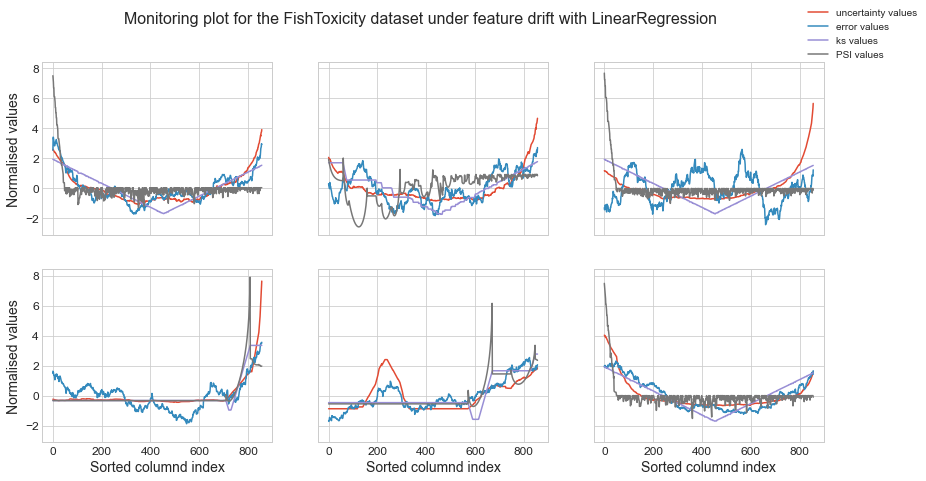

In [16]:
for dataset in dataset_classes:
    monitoring_plot(dataset,LinearRegression)



In [ ]:
for dataset in dataset_classes:
    monitoring_plot(dataset,XGBRegressor)

In [ ]:
kk

## Rolling window experiment

In [ ]:
dfs = {}
for dataset in dataset_classes:
    uncertainty_loop = []
    ks_loop = []
    psi_loop = []
    params = np.array(range(20,400,20))
    for rs in params:
        if dataset().shape[0] / 3 > rs:
            print(rs)
            res = monitoring_plot(dataset, LinearRegression, ROLLING_STAT=rs,plot=False)
            uncertainty_loop.append(res.loc["mean"][0])
            ks_loop.append(res.loc["mean"][1])
            psi_loop.append(res.loc["mean"][2])

    agg = pd.DataFrame([uncertainty_loop,ks_loop,psi_loop,params]).T
    agg.columns = ['uncertainty','ks','psi','parameters']
    dfs[dataset.__name__]=agg


In [ ]:

fig, axs = plt.subplots(1, len(dfs))
fig.suptitle("Impact of rolling window size over unsupervised model monitoring techniques")
for idx, key in enumerate(dfs.keys()):
    axs[idx].title.set_text("Dataset:{}".format(key))
    dt = dfs[key]
    dt["params"] = range(dt.shape[0])
    axs[idx].plot(dt["params"], dt["uncertainty"].values, label="Uncertainty")
    axs[idx].plot(dt["params"], dt["ks"].values, label="K-S")
    axs[idx].plot(dt["params"], dt["psi"].values, label="PSI")
    if idx ==2:
        axs[idx].legend(bbox_to_anchor=(1, 1))


plt.show()